In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pywt
from scipy.signal import welch

# Load data
data = pd.read_csv("/Users/eslifolkes/OpenBBUserData/exports/spx,vix,vvix,move,skew,shortvol.csv")
data['x'] = pd.to_datetime(data['x'])

# Handle missing VIX values (if using additional VIX data)
new_vix_data = pd.read_csv("/Users/eslifolkes/OpenBBUserData/exports/openbb_CBOE_S&P_500_Volatility_Index_20230904_043308.csv")
new_vix_data['x'] = pd.to_datetime(new_vix_data['x'])
merged_data = pd.merge(data, new_vix_data[['x', 'CBOE S&P 500 Volatility Index']], on='x', how='left', suffixes=('', '_new'))
merged_data['CBOE S&P 500 Volatility Index'].fillna(merged_data['CBOE S&P 500 Volatility Index_new'], inplace=True)
merged_data.drop(columns=['CBOE S&P 500 Volatility Index_new'], inplace=True)


## Data Analysis

In [8]:
# Calculate daily returns for the S&P 500
merged_data['SP500 Daily Returns'] = merged_data['S&P 500 Index'].pct_change()

# Compute the 30-day realized volatility
merged_data['30-day Realized Vol'] = merged_data['SP500 Daily Returns'].rolling(window=30).std() * np.sqrt(252)


## Visualization

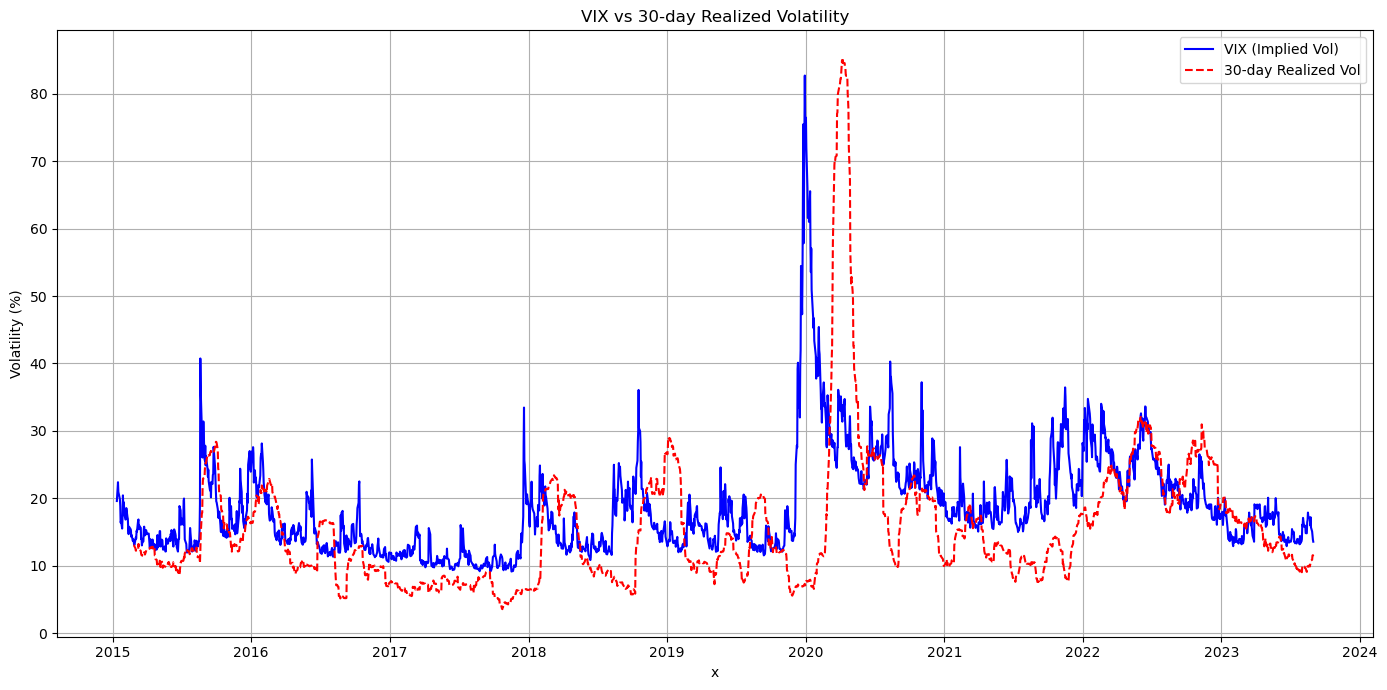

In [11]:
# VIX vs. 30-day Realized Volatility
plt.figure(figsize=(14,7))
plt.plot(merged_data['x'], merged_data['CBOE S&P 500 Volatility Index'], label='VIX (Implied Vol)', color='blue')
plt.plot(merged_data['x'], merged_data['30-day Realized Vol']*100, label='30-day Realized Vol', color='red', linestyle='--')
plt.title('VIX vs 30-day Realized Volatility')
plt.xlabel('x')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Correlation Analysis

In [13]:
# Overall Correlation
correlation_full_period = merged_data['CBOE S&P 500 Volatility Index'].corr(merged_data['30-day Realized Vol'])

# Rolling Correlation
window_size = 252  # Using a one-year window
rolling_correlation = merged_data['CBOE S&P 500 Volatility Index'].rolling(window=window_size).corr(merged_data['30-day Realized Vol'])

correlation_full_period, rolling_correlation.tail()


(0.33008413936481384,
 2170    0.680749
 2171    0.683952
 2172    0.684869
 2173    0.686462
 2174    0.689650
 dtype: float64)

## Regression Analysis

In [17]:
# Adjusting the rolling regression approach using a loop for simplicity and clarity

const_coefficients = []
slope_coefficients = []

for i in range(len(merged_data) - rolling_window + 1):
    subset = merged_data.iloc[i:i+rolling_window]
    y_subset = subset['30-day Realized Vol'].dropna()
    X_subset = sm.add_constant(subset['CBOE S&P 500 Volatility Index'].reindex_like(y_subset))
    
    model = sm.OLS(y_subset, X_subset).fit()
    
    const_coefficients.append(model.params[0])
    slope_coefficients.append(model.params[1])

# Appending NaN for the initial values where rolling regression cannot be computed
const_coefficients = [np.nan] * (rolling_window - 1) + const_coefficients
slope_coefficients = [np.nan] * (rolling_window - 1) + slope_coefficients

rolling_coeffs = pd.DataFrame({
    'const': const_coefficients,
    'slope': slope_coefficients
}, index=merged_data['x'])

rolling_coeffs.tail()


,const,slope
x,,
2023-08-25,-0.065966,0.014176
2023-08-28,-0.068760,0.014342
2023-08-29,-0.069836,0.014403
2023-08-30,-0.071270,0.014490
2023-08-31,-0.073502,0.014629


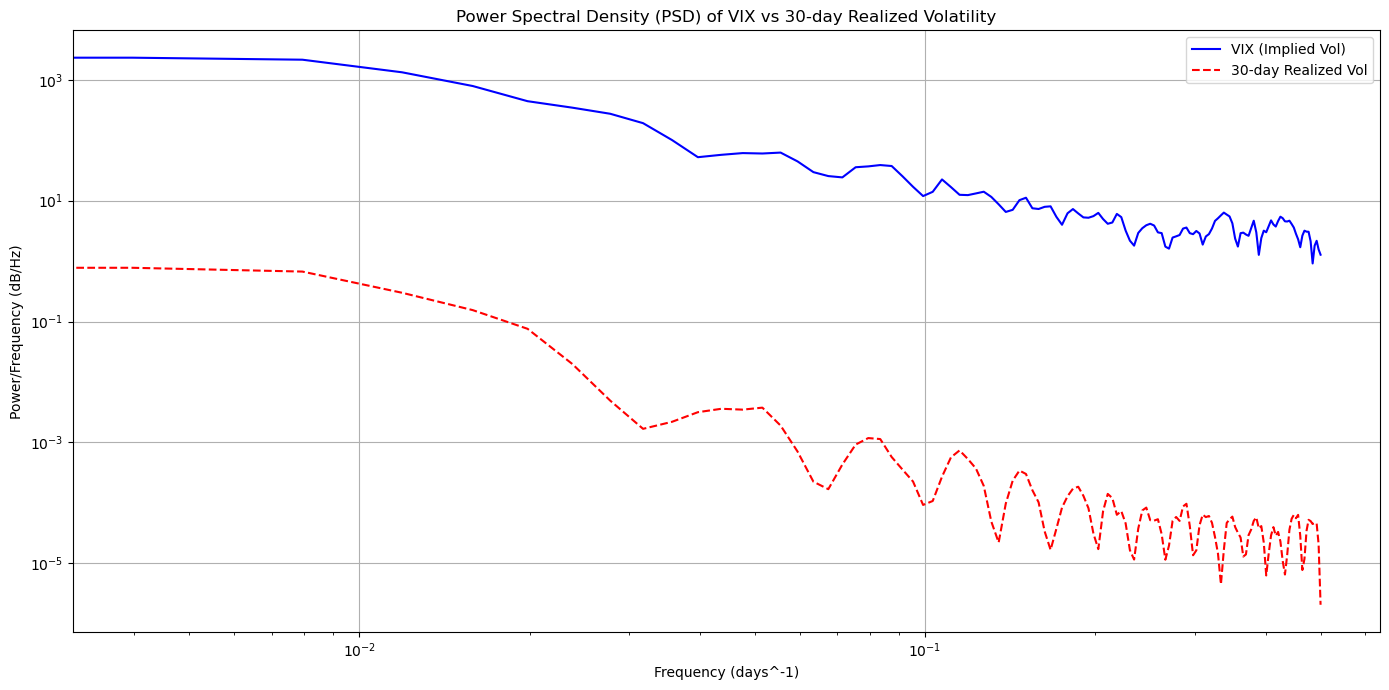

In [18]:
from scipy.signal import welch

# 3. Frequency Analysis

# 3.1 Apply Fourier transforms and power spectral density analysis
# For the VIX (Implied Volatility)
frequencies_vix, psd_vix = welch(merged_data['CBOE S&P 500 Volatility Index'].dropna(), nperseg=rolling_window)

# For the 30-day Realized Volatility
frequencies_realized_vol, psd_realized_vol = welch(merged_data['30-day Realized Vol'].dropna(), nperseg=rolling_window)

plt.figure(figsize=(14,7))
plt.loglog(frequencies_vix, psd_vix, label='VIX (Implied Vol)', color='blue')
plt.loglog(frequencies_realized_vol, psd_realized_vol, label='30-day Realized Vol', color='red', linestyle='--')
plt.title('Power Spectral Density (PSD) of VIX vs 30-day Realized Volatility')
plt.xlabel('Frequency (days^-1)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Frequency Analysis

/Users/eslifolkes/anaconda3/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


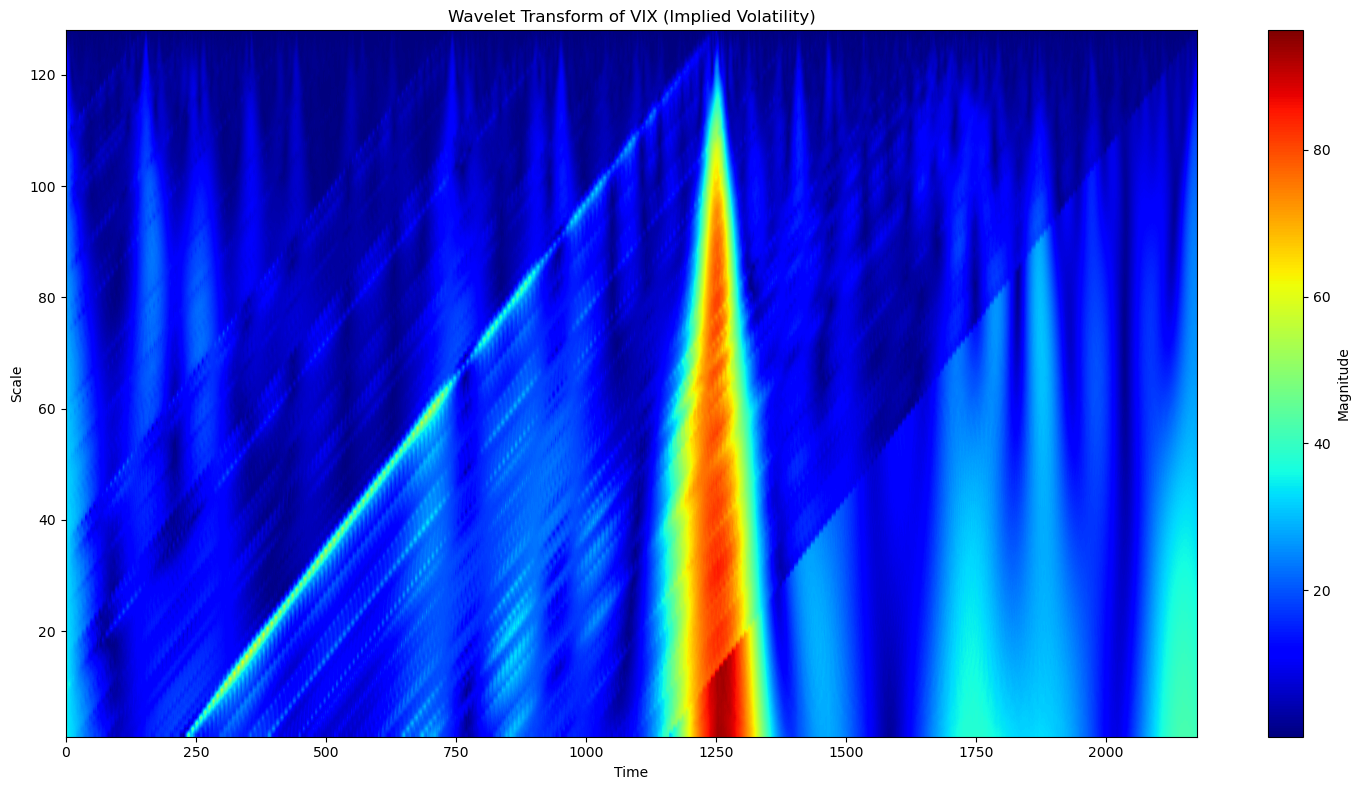

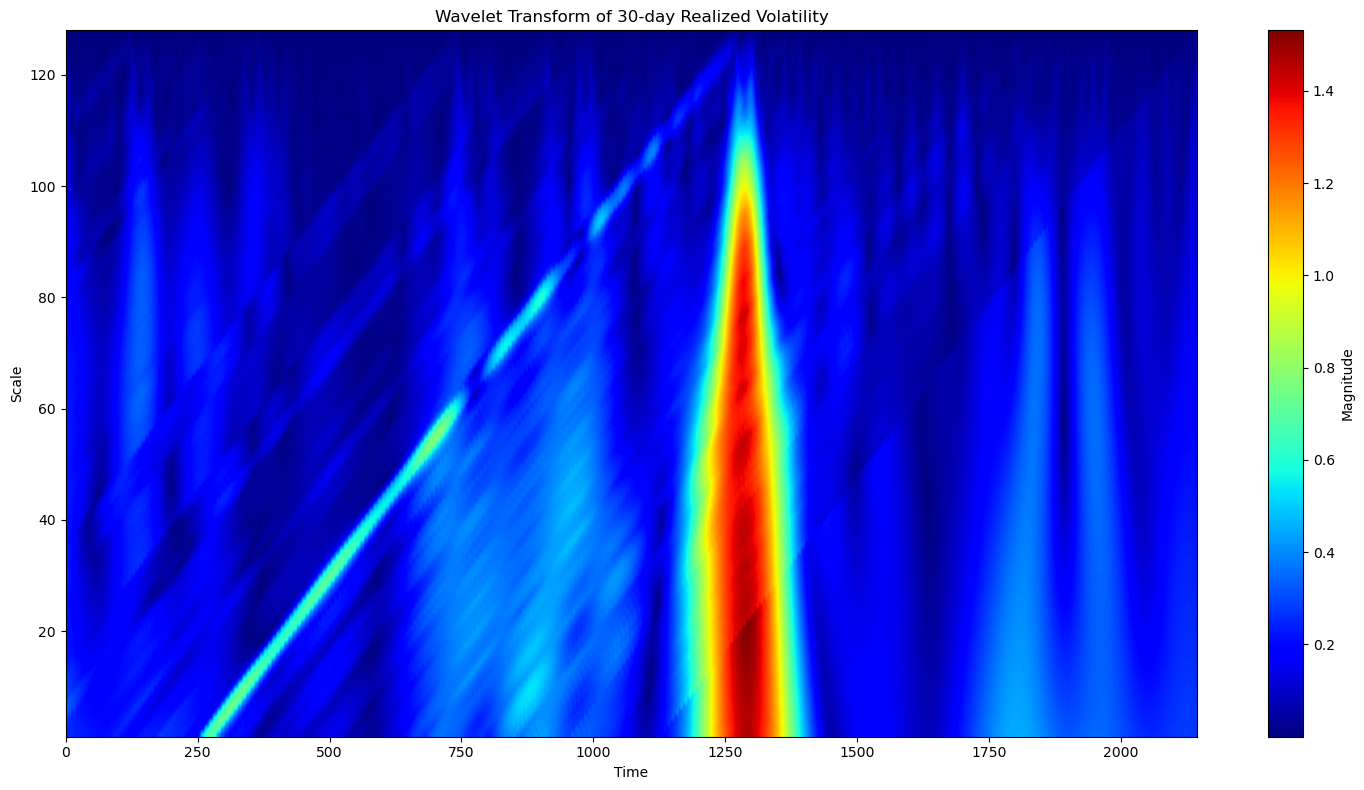

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

# Define a function to compute and visualize the Continuous Wavelet Transform (CWT)
def plot_cwt(data, title, wavelet='cmor'):
    # Compute CWT
    coefficients, frequencies = pywt.cwt(data, scales=np.arange(1, 128), wavelet=wavelet)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(data), 1, 128], cmap='jet', interpolation='bilinear')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.title(f'Wavelet Transform of {title}')
    plt.tight_layout()
    plt.show()

# Visualize CWT for VIX (implied volatility)
plot_cwt(merged_data['CBOE S&P 500 Volatility Index'].dropna().values, 'VIX (Implied Volatility)')

# Visualize CWT for 30-day Realized Volatility
plot_cwt(merged_data['30-day Realized Vol'].dropna().values, '30-day Realized Volatility')


## Transition Points and Comprative Analysis 

In [22]:
# Identify transition points in the market by examining the maxima in the wavelet coefficients across scales

# Compute the wavelet transform for both series
coefficients_vix, _ = pywt.cwt(merged_data['CBOE S&P 500 Volatility Index'].dropna().values, scales=np.arange(1, 128), wavelet='cmor')
coefficients_realized_vol, _ = pywt.cwt(merged_data['30-day Realized Vol'].dropna().values, scales=np.arange(1, 128), wavelet='cmor')

# Identify the scale with the maximum magnitude for each time point
dominant_scale_vix = np.argmax(np.abs(coefficients_vix), axis=0)
dominant_scale_realized_vol = np.argmax(np.abs(coefficients_realized_vol), axis=0)

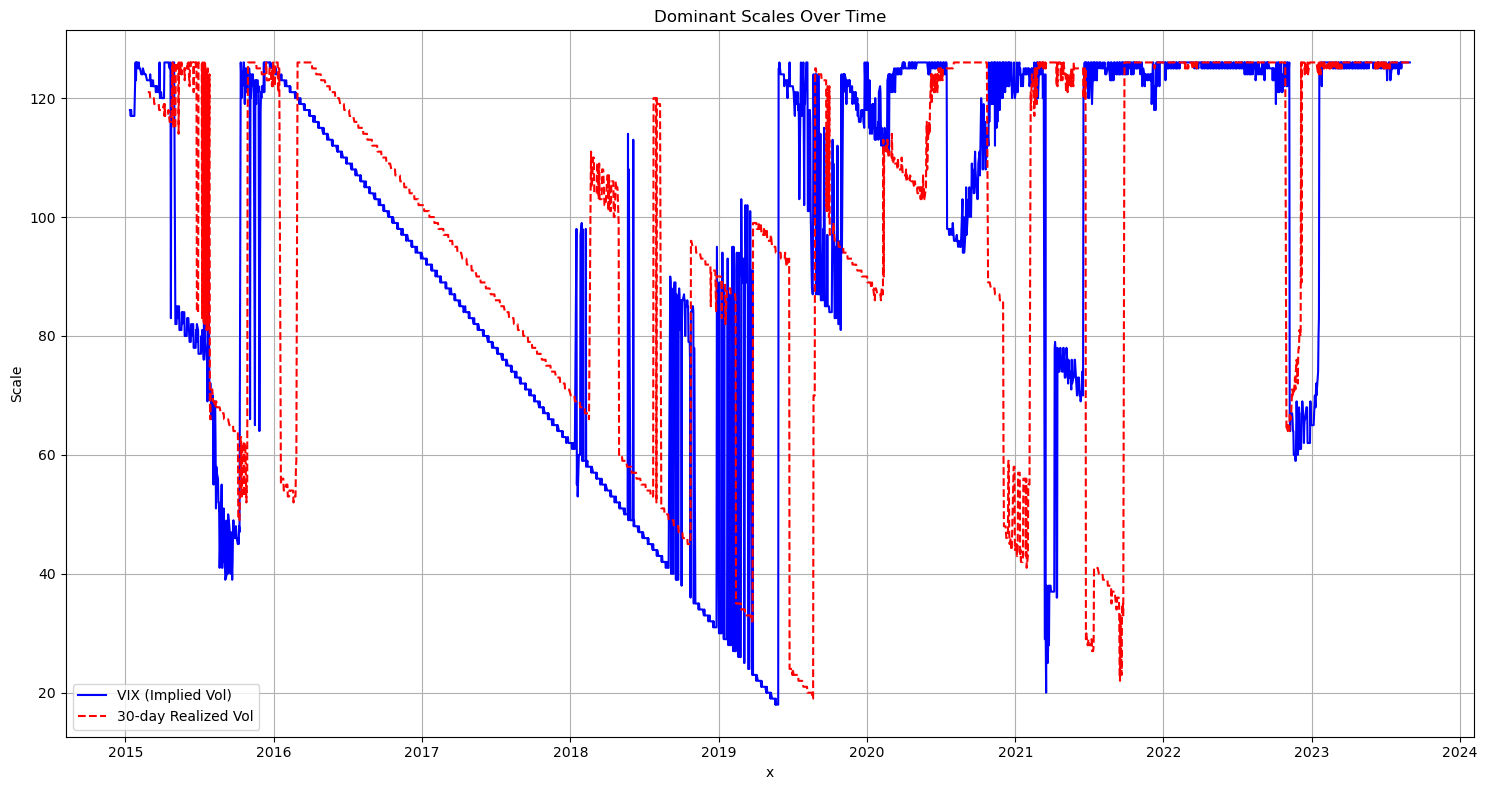

In [23]:
# Correct the mismatch in lengths by aligning the dominant scale series with the non-NaN values of the original series

dates_vix = merged_data['x'][merged_data['CBOE S&P 500 Volatility Index'].notna()].values
dates_realized_vol = merged_data['x'][merged_data['30-day Realized Vol'].notna()].values

# Plot the dominant scales over time with corrected date arrays
plt.figure(figsize=(15, 8))
plt.plot(dates_vix, dominant_scale_vix, label='VIX (Implied Vol)', color='blue')
plt.plot(dates_realized_vol, dominant_scale_realized_vol, label='30-day Realized Vol', color='red', linestyle='--')
plt.title('Dominant Scales Over Time')
plt.xlabel('x')
plt.ylabel('Scale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
